# Predict and Visualize

In [1]:
import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T

from ntm import NTM
from task_generator import CopyDataset, AssociativeDataset

## Task Data

In [2]:
# ==== Load the Task Configuration files ====
# Copy Task ===
task_params = json.load(open('configs/copy.json'))
task_params['min_seq_len'] = 60
task_params['max_seq_len'] = 120

# Associative Recall Task ===
# task_params['min_item'] = 6
# task_params['max_item'] = 9

In [3]:
# ==== Create Dataset ====
dataset = CopyDataset(task_params)

## Model

In [4]:
# ==== Create NTM ====
ntm = NTM(input_dim=task_params['seq_width'] + 2,
          output_dim=task_params['seq_width'],
          ctrl_dim=task_params['controller_size'],
          memory_units=task_params['memory_units'],
          memory_unit_size=task_params['memory_unit_size'],
          num_heads=task_params['num_heads'])

In [5]:
# Load trained model weights
ntm.load_state_dict(torch.load('model_copy.pt'))

<All keys matched successfully>

## Prediction Step

In [8]:
# Reset
ntm.reset()

# Sample data
data = dataset[np.random.randint(65536)]
inputs, target = data['input'], data['target']

# Tensor to store outputs
out = torch.zeros(target.size())

# Process the inputs through NTM for memorization
for i in range(inputs.size()[0]):
    # Forward passing all sequences for read
    ntm(inputs[i].unsqueeze(0))

# Get the outputs from memory without real inputs
zero_inputs = torch.zeros(inputs.size()[1]).unsqueeze(0) # dummy inputs
for i in range(target.size()[0]):
    out[i] = ntm(zero_inputs)

# Calculate binary outputs
binary_output = out.clone()
binary_output = binary_output.detach().apply_(lambda x: 0 if x < 0.5 else 1)

# Sequence prediction error is calculted in bits per sequence
error = torch.sum(torch.abs(binary_output - target))
print(f'Error: {error} bits per sequence')

Error: 0.0 bits per sequence


## Visualize

In [21]:
# Transforms Compose object
visualize = T.Compose([T.ToPILImage(), T.Resize(128, interpolation=0)])

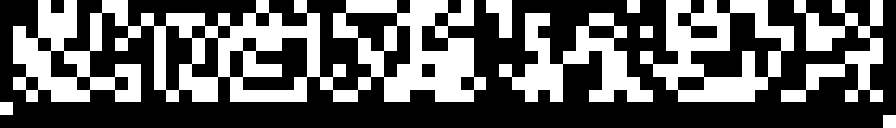

In [22]:
# Visualize Input
visualize(inputs.permute(1, 0))

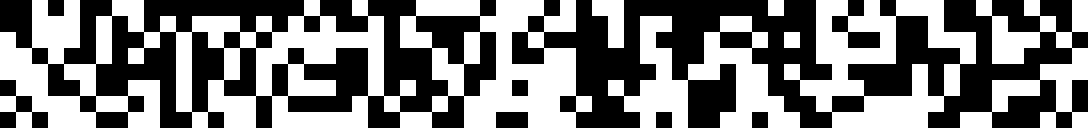

In [23]:
# Visualize Predicted Output
visualize(binary_output.permute(1, 0))